<a href="https://colab.research.google.com/github/HendrixOB/ProyectoII/blob/main/Tarea2/Proyecto_II_Tarea2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import torch
import matplotlib
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
import tensorflow as tf
from collections import OrderedDict
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
matplotlib.style.use('ggplot')

<font color="Teal" face="Comic Sans MS,arial">
  <h1 align="center"><i>[Tarea 2] Clasificación categórica de imágenes de flores usando redes neuronales</i></h1>
  </font>
  <font color="Black" face="Comic Sans MS,arial">
  <h5 align="center"><i>Profesora: María Fernanda Sánchez Puig
</i></h5>
    <h5 align="center"><i>Ayudante: Sergio Miguel Fernández Martínez</i></h5>
  <h5 align="center"><i>Materia: Proyecto II</i></h5>
  <h5 align="center"><i>Alumno: Hendrix Roberto Olvera Barbecho</i></h5>
  </font>

# Revisar disponiblidad del gpu

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

print(device)

cuda


# Carga de datos desde Colab

In [3]:
from google.colab import drive # Colab
drive.mount('/content/drive') # Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root = root = "/content/drive/MyDrive/17flowers/jpg"

Las imágenes que se usaran en este notebook estan divididas en varias carpetas, cada carpeta representa una especie de flor. Veamos la estrucura del directorio:
```
...17flowers
  +- jpg
    +- 0
    +- 1
    +- 2
    ...
    +- 15
    +- 16
```

# Definición de categorías de flores

In [5]:
dic = {0: 'Daffodil', 1: 'Snowdrop', 2: 'Daisy', 3: 'ColtsFoot', 4: 'Dandelion', \
       5: 'Cowslip', 6: 'Buttercup', 7: 'Windflower', 8: 'Pansy', 9:'LilyValley', \
       10: 'Bluebell', 11: 'Crocus', 12: 'Iris', 13: 'Tigerlily', 14:'Tulip', \
       15: 'Fritillary', 16: 'Sunflower'}
       
num_classes = len(dic)

# 1. Ejercicio: Definición del conjunto de datos con *data augmentation*.


a)  Busca 5 funciones en el módulo `torchvison.transforms` que permitan alterar a las imagenes del *dataset*. Visita la documentación de [torchvison.transforms](https://pytorch.org/vision/stable/transforms.html). Explica brevemente cada una de las transformaciones.

b)  Define tu propia transformación `my_transform` utilizando `transforms.Compose` para concatenar las transformaciones que encontraste para alterar las imagenes y poder efectuar el proceso de *data augmentation* sobre el conjunto de datos. No olvides incluir `transforms.Resize` además de las otras 5 transformaciones.

**Observación:** asegurate de usar transformaciones que se apliquen de forma aleatoria, en caso contrario utiliza la función `transforms.RandomApply`. A continuación se muestra un ejemplo de su uso:
```
transform = [transforms.Pad(100, fill=(0, 255, 255)), transforms.CenterCrop(100), transforms.RandomRotation(20)]
transform = transforms.Compose([
    transforms.RandomApply(transform, p=0.5)
])
```
Recuerda que el efecto que se busca es aumentar el tamaño del dataset de forma artificial.

**Recomendación**: visita el notebook visto en la clase 15 de la semana 6.

In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [7]:
my_transform = transforms.Compose([transforms.Resize((224,224)),
  transforms.RandomGrayscale(p=0.5), #Escala a grises la imagen, es decir, convierte a blanco y negro con proba p.
  transforms.RandomPerspective(distortion_scale=1, p=0.5, interpolation=2), #Realice aleatoriamente la transformación de perspectiva en una imagen con proba p  
  transforms.RandomHorizontalFlip(p=0.5), #Gira horizontalmente la imagen dada con una proba P
  transforms.ToTensor(),
  transforms.RandomInvert(p=0.5), #Invierte el color de la imagen da con una proba p
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
  transforms.RandomErasing(p=0.5), #Selecciona una región de la imagen, de forma aleatoria con proba p, la convierte en una imagen tensor.
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:734: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
#dataset = ImageFolder(root, transform=transforms.Resize((224,224)))
dataset = ImageFolder(root, transform=my_transform)

# 2. Ejercicio: Visualización de imagenes transformadas.

Asegurate que efectivamente se esta aumentando 
el tamaño del *dataset* de forma artificial. Utiliza la función `show_image` para graficar una imagen de `dataset` varias veces de tal forma que se vean distintas transformaciones de la misma imagen. Recuerda que es necesario transformar la imagen de `torch` a `numpy` para poder graficar, los tensores tienen el método `numpy()` para hacer dicha transformación.

In [9]:
def show_image(img):
    np_img = img
    np_img = img.numpy().transpose((1, 2, 0))
    np_img = np.copy(np_img)
    plt.imshow(np_img)
    plt.show()

#3. Ejercicio: Definición de conjunto entrenamiento y validación.

Separa el conjunto `dataset` en los conjuntos `train_set` y `val_set`. Asegurante de que $20 \%$ de los datos pertenezca al conjunto de validación. Sugerencia divide los indices de forma aleatoria y en proporción y utiliza la clase `torch.utils.data.Subset`.

In [10]:
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


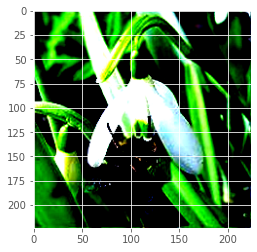

class: Snowdrop


In [11]:
index = 10
show_image(train_dataset[index][0])
clase = train_dataset[index][1]
print('class: '+ dic[clase])

#4. Ejercicio: Definición del *Dataloader*.

Divide en *batchs* de tamaño 32 y crea una instacia de `torch.utils.data.Dataloader` para `train_set` y `val_set`. Recuerda usar la bandera `shuffle` para revolver los datos.

In [12]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=128, shuffle=True)

# 5. Ejercicio: Declaración de la red neuronal con capas convolucionales.

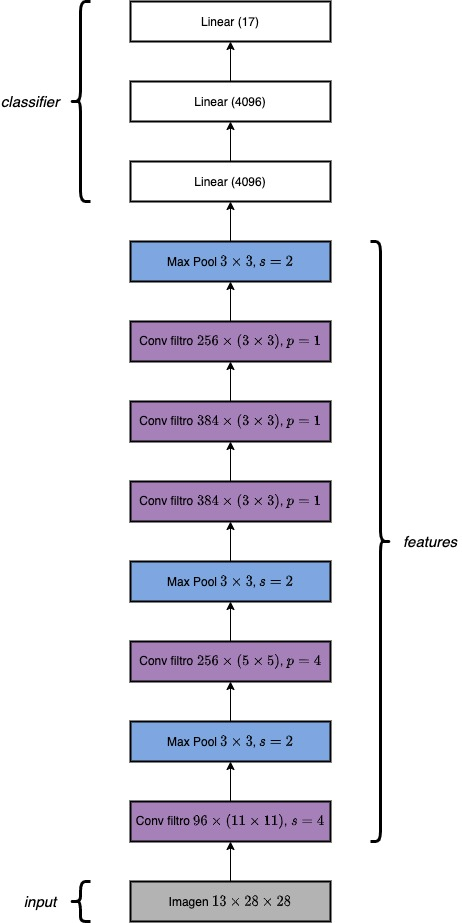

Utilizando el módulo `torch.nn` crea una red neuronal con la arquitectura del popular modelo **AlexNet** considerando 17 clases. Realiza los siguientes pasos:

a) Utilizando el diagrama anterior calcula las dimensiones faltantes del siguiente diagrama. 

<center>
<img src="https://github.com/HendrixOB/ProyectoII/blob/main/Imagenes/AlexNetcalculado.jpg?raw=1" width="1000"> 
</center>

b) Calcula la dimesión de los valores de entrada de la parte FNN de la red. Usa la expresión $c \cdot h \cdot w$
donde $c, h$ y $w$ son el número de canales, largo y ancho de la salida de la última capa  de la  parte CNN, respectivamente.

Tenemos una imagen que entra con $\color{gray}{3 \times 224 \times 224}$ aqui podemos ver que $w=224$, del primer `Conv` vemos que nuestro kernel es $k=11$ y dentremos un pading $p=2$ y recordemos que podemos calcular con:    

$$\frac{w-k+2p}{s}+1$$

Donde $s$ es el stride, entonces obtenemos:            

* $\color{purple}{z_{1}:}$ con un stride $s=4$, entonces $\color{purple}{\frac{224-11+2(2)}{4}+1 = 55}$ por lo que $\color{purple}{96 \times 55 \times 55}$ y se actualiza $w=55$.
* $\color{blue}{p_{1}:}$ el stride cambia a $s=2$ y al no contar con pading tenemos $p=0$, en `MaxPool` se nos dice que el Kernel es $k=3$ $\color{blue}{\frac{55-3+2(0)}{2}+1 = 27}$ por lo tanto $\color{blue}{256 \times 27 \times 27}$, $w$ se actualiza a $w=27$.
* $\color{purple}{z_{2}:}$ se muestra un kernel de 5, un pading de 2, al no tener stride lo definiremos $s=1$ $\color{purple}{\frac{27-5+2(2)}{1}+1 = 27}$ y obtenemos $\color{purple}{256 \times 27 \times 27}$.
* $\color{blue}{p_{2}:}$ nuestro kernel apartir de aqui ya no cambiara y se mantendra en $k=3$, nuestras pading y stride seran iguales a 1 hasta en los siguientes `Conv`, aqui solo el stride sera 2 y el pading 0. Calculamos  $\color{blue}{\frac{27-3+2(0)}{2}+1 = 13}$, se actualiza $w=13$ para los siguientes `Conv`, obteniendo $\color{blue}{256 \times 13 \times 13}$.
* $\color{purple}{z_{3}:}$ calculemos $\color{purple}{\frac{13-3+2(1)}{1}+1 = 13}$ y  obtenemos $\color{purple}{384 \times 13 \times 13}$.
* $\color{purple}{z_{4}:}$ calculemos $\color{purple}{\frac{13-3+2(1)}{1}+1 = 13}$ y obtenemos $\color{purple}{384 \times 13 \times 13}$.
* $\color{purple}{z_{5}:}$ calculemos $\color{purple}{\frac{13-3+2(1)}{1}+1 = 13}$ y obtenemos $\color{purple}{256 \times 13 \times 13}$.
* $\color{blue}{p_{5}:}$ tenemos un stride de 2 y al no tener pading es 1 $\color{blue}{\frac{13-3+2(0)}{2}+1 = 6}$, por lo tanto $\color{blue}{256 \times 6 \times 6}$.

c) Completa el siguiente código considerando las diemensiones que calculaste en b). Deberás declarar los siguientes atributos o secciones de `AlexNet`: 

*   `features`: corresponde a la parte convolucional de la red.
*   `flatten`: corresponde a la transición entre la parte convolucional y la parte completamente conectada.
*   `classifier`: corresponde a la parte completamente conectada de la red.

Estos tres atributos deberán ser llamados en el método `forward` para definir el flujo de información. Recuerda incluir *padding* y *stride* donde sea necesario.

Utiliza *dropout* con probabilidad $0.5$ en las capas intermedias de `classifier`, es decir, aplica *dropout* antes de las capas $z_6$ y $z_7$). 

**Hint:** Utiliza la clase `nn.Sequential` agrupar funciones de cada seccion de `AlexNet`. Ocupa `nn.Flatten` para aplanar la salida de última capa convolucional. Revisa el documento **LeNet.pdf** para ver como calcular las dimensiones en cada capa. Visita la documentación o revisa los ejemplos vistos en clase. 

In [13]:
from torch import nn

class AlexNet(nn.Module):

    def __init__(self, num_classes=17):
        super(AlexNet, self).__init__()
        self.features =nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.flatten =  nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*6* 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
      
    def forward(self, x):
      x = self.features(x)
      x = self.flatten(x)
      return self.classifier(x)

In [14]:
net = AlexNet(17)
net = net.to(device)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2

In [15]:
#foo = nn.Linear(384 * 6 * 6, 4096)
#x = torch.rand(size=(1, 384*6*6), dtype=torch.float32)
#foo(x).shape

#6. Ejercicio: Selección de optimizador y función de costos.

a) Investiga cómo declarar el optimizador que presentaste en la exposición de algoritmos de optimización de redes neuronales utilizando el módulo `torch.optim`. Revisa la documentación en la sección *Algorithms* de dicho módulo, puedes encontrar la página web [aquí](https://pytorch.org/docs/stable/optim.html).

In [16]:
from torch import optim
optimizer = optim.SGD(net.classifier.parameters(),lr=0.1,momentum=0.9)

b) Utiliza la función de costos de *categorical cross entropy*.

In [17]:
criterion = nn.CrossEntropyLoss()

#7. Ejercicio: Entrenamiento.

 a) Diseña una función que ajuste los paramétros por *epoch* y registre la pérdida y precisión después de cada *forward pass*. Asegúrate de considerar que los datos estén habilitados en `device`.

In [18]:
def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct, total = 0,0
  for i, (features, targets) in enumerate(dataloader, 0):
    features = features.to(device) # Por si hay gpu
    targets = targets.to(device) # Por si hay gpu
    logits = model(features)
    _, predicted_labels = torch.max(logits,1)

    total += targets.size(0)
    correct += (predicted_labels == targets).sum() 
    loss = criterion(logits, targets)

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    acc = correct.float()/total *10
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(targets.shape[0])
  return avg_loss, acc

b) Diseña el ciclo del entrenamiento. Asegúrate de guardar en un arreglo la pérdida y precisión de cada *epoch*. Entrena la red durante 40 *epochs*.

In [19]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
  train_time = 0
  epoch_loss = list(); epoch_acc = list()
  val_loss = list(); val_acc = list()

  n_train = len(train_loader.dataset)
  n_val = len(val_loader.dataset)
  model.train() # -> aplica drop si lo tiene el modelo y lleva registro de los gradientes
  for epoch in range(epochs):
    start_time = time.time()
    with tqdm(total=n_train, position=0) as pbar_train:
      pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - train')
      pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
      loss_train, acc_train = fit(model, train_loader, optimizer, criterion, pbar_train)
      train_time +=  time.time() - start_time
    model.eval() 
    with tqdm(total=n_val, position=0) as pbar_val:
      pbar_val.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - val')
      pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
      loss_val, acc_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)

    val_loss.append(loss_val)
    val_acc.append(acc_val)

  return epoch_loss, epoch_acc, val_loss, val_acc, train_time

In [20]:
epochs = 40
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(net, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 40/40 - val: 100%|██████████| 272/272 [00:03<00:00, 78.24it/s, acc=0.5882, avg_loss=2.8327]


 --- %s seconds --- 563.0719084739685


c) Grafica los arreglos de pérdida y precisión.

In [21]:
def graficas(epoch_acc, val_acc, epoch_loss, val_loss):
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))
  ax1.plot(epoch_acc, label='Data Train (datos de entrenamiento)', color ="green")
  ax1.plot(val_acc, label='Data Validation (datos de validacion)', color="yellow")
  ax1.set_title('Precision del modelo')
  ax1.set_ylabel('Precision')
  ax1.set_xlabel('epoch')
  ax1.legend()

  ax2.plot(epoch_loss, label='Data Train (datos de entrenamiento)')
  ax2.plot(val_loss, label='Data Validation (datos de validacion)')
  ax2.set_title('Perdida del modelo')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('epoch')
  ax2.legend()
  plt.show()

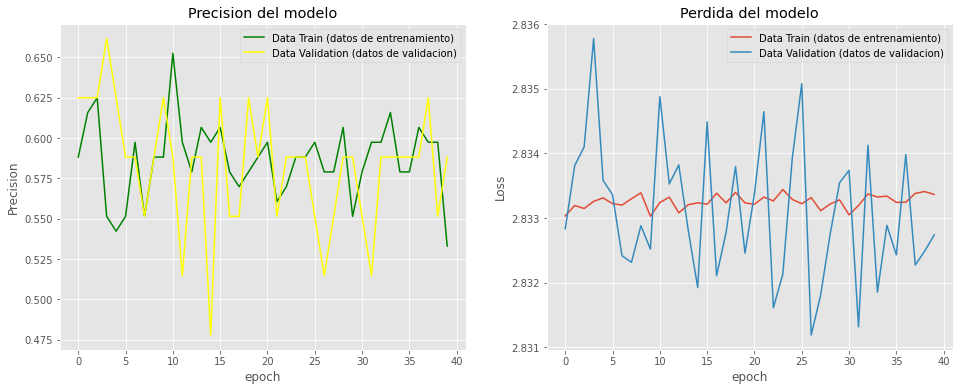

In [22]:
graficas(epoch_acc, val_acc, epoch_loss, val_loss)

# 8. Ejercicio: *Transfer learning*.

a) Del módulo `torchvison.models` carga la red ya entrenada de AlexNet.

In [23]:
import torchvision.models as models
other_net = models.alexnet()
print(other_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

En este caso la red cargada tiene $1,000$ valores de salida.

b) Cambia la última capa de `other_net.classifier` de tal forma que tenga $17$ valores de salida. 

In [24]:
other_net.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216,out_features=384*6*6,bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=384*6*6,out_features=4096,bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096,out_features=4096,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096,out_features=17,bias=True)
)

c) Cambia el valor `p` de las capas con *dropout*, establece $p=0.4$.

In [25]:
other_net.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=9216,out_features=384*6*6,bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=384*6*6,out_features=4096,bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=4096,out_features=4096,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096,out_features=17,bias=True)
)

In [26]:
import torchvision.models as models
other_net = other_net.cuda()
print(other_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=9216, out_features=13824, bias=True)


In [27]:
other_net = other_net.to(device)

# 9. Ejercicio: Entrenamiento con *transfer learning*

a) Congela las capas de `other_net.features` para que sólo sea necesario entrenar las capas de `other_net.classifier`.

In [28]:
for param in other_net.features.parameters(): param.requires_grad = False

if torch.cuda.is_available():
  other_net = other_net.cuda()

print(other_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=9216, out_features=13824, bias=True)


b) Entrena durante $10$ *epochs* la red `other_net`.

In [29]:
epochs = 10
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(other_net, train_loader, val_loader, optimizer, criterion, epochs)
print("\n --- %s seconds ---", train_time)

Epoch 10/10 - val: 100%|██████████| 272/272 [00:03<00:00, 76.08it/s, acc=0.5882, avg_loss=2.8329]


 --- %s seconds --- 140.3912971019745


c) Grafica la función de pérdida y precisión en cada paso.

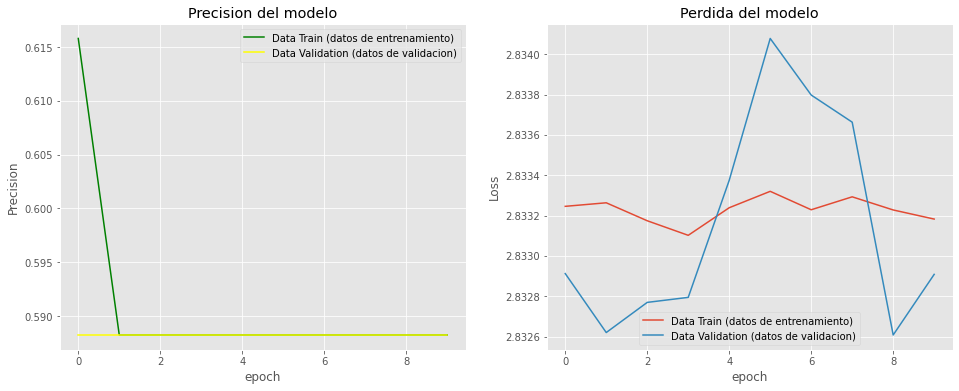

In [30]:
graficas(epoch_acc, val_acc, epoch_loss, val_loss)

# 10. Ejercicio: Mi conclusión.

Describe brevemente tus observaciones de este *notebook*. Menciona las diferencias entre los entrenamientos realizados en los ejercicios 7 y 9 ¿Qué entrenamiento fue mejor y porqué piensas que suecede esto?

En la mayoría de las veces que se corrió el código nos daba una mejor precisión en el segundo modelo, las principales diferencias de nuestros modelos son: 

* El modelo AlexNet definido en el inciso 7, va directo a clasificar las 17 diferentes opciones, mientras que el modelo `AlexNet` de `models` se debe modificar para obtener 17, lo que nos da un paso más para este proceso.

* Y algo que puede llamar la atención es que en muchas pruebas del código en `AlexNet` de `modeles` nos deja con un entrenamiento y validación constante o después de cierto epoch las predicciones las da constantes. 

Algo importante de mencionar es que el congelamiento es más sencillo de lograr una vez que ya se pudo definir bien `AlexNet`, ya que en este proceso lo difícil es el calculo de las diferentes dimensiones, una vez hecho esto en `other_net` es más fácil de lograr por las funciones `Lineal()` y ya no tener que calcular las dimensiones.

Anteriormente se menciono que en la mayoría de las ocasiones `other_net` inputaba mejores predicción, sin embargo hay que notar que las diferencias de predicción no eran tan grandes.    
